In [7]:
 # This file will use the random forest algorithm to classify the text in the dataset to predict the polarity of the text.
    # The dataset is a collection of reddit post that is manually labeled as positive or negative.

# Import the necessary libraries
# Data Processing
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Modelling 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset Preparation

In [8]:
# Import the dataset
R_df = pd.read_csv('../Data/Relevance.csv')
# R2_df = pd.read_csv('../Data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['Polarity', 'ID', 'Date', 'Query', 'User', 'Data'])
# R_df = pd.read_csv('../Data/relevance_undersampled.csv')
# R_df = pd.read_csv('../Data/eda_relevance.csv')


P_df = pd.read_csv('../Data/Polarity.csv')
# P_df = pd.read_csv('../Data/polarity_undersampled.csv')
# P_df = pd.read_csv('../Data/eda_polarity.csv')

In [9]:
# # Remove special characters from Title and Data columns such as as ð,Ÿ,˜,â,€,™, and ðŸ˜
R_df['Data'] = R_df['Data'].str.replace('ðŸ˜','')
R_df['Data'] = R_df['Data'].str.replace('ðŸ‘€','')
# Remove ðŸ
P_df['Data'] = P_df['Data'].str.replace('ðŸ˜','')
P_df['Data'] = P_df['Data'].str.replace('ðŸ‘€','')

# # Replace all the NaN values with empty string
R_df['Data'] = R_df['Data'].fillna('')
R_df['Relevance'] = R_df['Relevance'].fillna('')
P_df['Data'] = P_df['Data'].fillna('')    
P_df['Polarity'] = P_df['Polarity'].fillna('')

# Replace \n with empty string
R_df['Data'] = R_df['Data'].str.replace('\n','')
P_df['Data'] = P_df['Data'].str.replace('\n','')

# Flags to run either the Relevance or polarity model
relevance = True
polarity = True
polarity_join = False

# if polarity_join:
#     # Drop all columns except Polarity and Data
#     R2_df = R2_df.drop(['ID', 'Date', 'Query', 'User'], axis=1)
#     print(R2_df.columns.values)
#     # Iterate through R2_df and change polarity to 1 if it is 4, -1 if it is 0 and 0 if it is 2
#     for index, row in R2_df.iterrows():
#         if row['Polarity'] == 4:
#             R2_df.at[index, 'Polarity'] = 1
#         elif row['Polarity'] == 0:
#             R2_df.at[index, 'Polarity'] = -1
#         else:
#             R2_df.at[index, 'Polarity'] = 0


In [10]:
# Preprocessing Function for each data
def preprocess_bows(df, df_size):
    data_soup = BeautifulSoup(df)
    data_text = data_soup.get_text()
    data_letters_only = re.sub("[^a-zA-Z]", " ", data_text).lower()
    data_words = data_letters_only.split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in data_words if not w in stops]

    if((i)%1000 == 0):
        print("Cleaned %d %d data (%d %%)." % (i, df_size, (i/df_size)*100))
    return(" ".join(meaningful_words))

In [11]:
# Preprocess the data
R_df_size = R_df['Data'].size
P_df_size = P_df['Data'].size

if relevance:
    for i in range(R_df_size):
        R_df['Data'][i] = preprocess_bows(R_df['Data'][i], R_df_size)
    print("Relevance Data Cleaned")

if polarity:
    for i in range(P_df_size):
        P_df['Data'][i] = preprocess_bows(P_df['Data'][i], P_df_size)
    print("Polarity Data Cleaned")

    if polarity_join:
        # Join the two dataframes
        P_df = P_df.append(R2_df, ignore_index=True)

Cleaned 0 4300 data (0 %).


/var/folders/2q/bjqpws1153b0_y18lhffmh_m0000gn/T/ipykernel_23339/1679288590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  R_df['Data'][i] = preprocess_bows(R_df['Data'][i], R_df_size)


Cleaned 1000 4300 data (23 %).
Cleaned 2000 4300 data (46 %).
Cleaned 3000 4300 data (69 %).
Cleaned 4000 4300 data (93 %).
Relevance Data Cleaned
Cleaned 0 4300 data (0 %).


/var/folders/2q/bjqpws1153b0_y18lhffmh_m0000gn/T/ipykernel_23339/1679288590.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_df['Data'][i] = preprocess_bows(P_df['Data'][i], P_df_size)


Cleaned 1000 4300 data (23 %).
Cleaned 2000 4300 data (46 %).
Cleaned 3000 4300 data (69 %).
Cleaned 4000 4300 data (93 %).
Polarity Data Cleaned


In [12]:
# Prepare Training Features

if relevance:
    R_cv = CountVectorizer( analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features=5000)
    X_R = R_df['Data']
    y_R = R_df['Relevance']

    # Split the dataset into training and testing set
    X_R_train, X_R_test, y_R_train, y_R_test = train_test_split(X_R, y_R, test_size=0.3, random_state=42)
    print("Relevance test split done")
    print(X_R_train.shape, X_R_test.shape, y_R_train.shape, y_R_test.shape)

if polarity:
    P_cv = CountVectorizer( analyzer='word', tokenizer=None, preprocessor=None, stop_words=None, max_features=5000)
    # X = P_df.drop('Polarity', axis=1)
    X_P = P_df['Data']
    y_P = P_df['Polarity']

    # Split the dataset into training and testing set
    X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.3, random_state=42)
    print("Polarity test split done")
    print(X_P_train.shape, X_P_test.shape, y_P_train.shape, y_P_test.shape)

Relevance test split done
(3010,) (1290,) (3010,) (1290,)
Polarity test split done
(3010,) (1290,) (3010,) (1290,)


In [13]:
# Convert train, validation and test data to vectors
if relevance:
    X_R_train = R_cv.fit_transform(X_R_train)
    X_R_test = R_cv.transform(X_R_test)
    X_R_train = X_R_train.toarray()
    X_R_test = X_R_test.toarray()
if polarity:
    X_P_train = P_cv.fit_transform(X_P_train)
    X_P_test = P_cv.transform(X_P_test)
    X_P_train = X_P_train.toarray()
    X_P_test = X_P_test.toarray()


In [14]:
if relevance:
    vocab_R = R_cv.get_feature_names_out()
    print(vocab_R)
if polarity:
    vocab_P = P_cv.get_feature_names_out()
    print(vocab_P)
    distribution_P = np.sum(X_P_train, axis=0)
    print("Printing first 10 vocab-dist pairs:")
    for tag, count in zip(vocab_P[:10], distribution_P[:10]):
        print(count, tag)

['aaml' 'ab' 'abilities' ... 'zipper' 'zverev' 'zverevs']
['aaml' 'ab' 'abilities' ... 'zipper' 'zverev' 'zverevs']
Printing first 10 vocab-dist pairs:
5 aaml
4 ab
5 abilities
9 ability
51 able
7 absolu
5 absolueml
10 absoluml
7 absolute
25 absolutely


In [15]:
# # Encode the labels
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_P_train = le.fit_transform(y_P_train)
# y_P_test = le.fit_transform(y_P_test)

# Fitting and Training the model
if relevance:
    rf_R = RandomForestClassifier()
    rf_R.fit(X_R_train, y_R_train)
    print("Relevance Model Fitted")
if polarity:
    rf_P = RandomForestClassifier()
    rf_P.fit(X_P_train, y_P_train)
    print("Polarity Model Fitted")


Relevance Model Fitted
Polarity Model Fitted


In [16]:
# Predicting the test set results
if relevance:
    y_R_pred = rf_R.predict(X_R_test)
    confidence = rf_R.predict_proba(X_R_test)
    # print confidence of first 10 predictions
    print(confidence[:10])
    print("Relevance Accuracy: ", accuracy_score(y_R_test, y_R_pred))
    f1_score(y_R_test, y_R_pred, average='macro')
    print("Relevance F1 Score: ", f1_score(y_R_test, y_R_pred, average='macro'))

    print("Relevance Classification Report: ")
    print(classification_report(y_R_test, y_R_pred, digits=4))
if polarity:
    y_P_pred = rf_P.predict(X_P_test)
    print("Polarity Accuracy: ", accuracy_score(y_P_test, y_P_pred))
    f1_score(y_P_test, y_P_pred, average='micro')
    print("Polarity F1 Score: ", f1_score(y_P_test, y_P_pred, average='micro'))

    print("Polarity Classification Report: ")
    print(classification_report(y_P_test, y_P_pred, digits=4))

[[0.01       0.5        0.24777778 0.         0.06527778 0.17694444]
 [0.         0.31       0.49766667 0.         0.07       0.12233333]
 [0.         0.39035714 0.22783333 0.         0.01547619 0.36633333]
 [0.         0.4321627  0.19551984 0.         0.14546825 0.22684921]
 [0.         0.22894444 0.30666667 0.         0.04       0.42438889]
 [0.         0.28       0.56       0.         0.02       0.14      ]
 [0.         0.8845754  0.1154246  0.         0.         0.        ]
 [0.01       0.71       0.08       0.         0.13       0.07      ]
 [0.         0.14039683 0.66       0.         0.13960317 0.06      ]
 [0.         0.22791134 0.74208866 0.         0.02       0.01      ]]
Relevance Accuracy:  0.5565891472868217
Relevance F1 Score:  0.2676398979113112
Relevance Classification Report: 
              precision    recall  f1-score   support

                 0.0000    0.0000    0.0000         3
           0     0.6106    0.7707    0.6814       641
           1     0.5255    0.470

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Polarity Accuracy:  0.6527131782945736
Polarity F1 Score:  0.6527131782945736
Polarity Classification Report: 
              precision    recall  f1-score   support

          -1     0.6522    0.1935    0.2985       155
           0     0.6847    0.8776    0.7692       809
           1     0.4928    0.3129    0.3827       326

    accuracy                         0.6527      1290
   macro avg     0.6099    0.4614    0.4835      1290
weighted avg     0.6323    0.6527    0.6150      1290



Relevance Confusion Matrix: 
[[  0   0   3   0   0   0]
 [  0 494 104   0  15  28]
 [  0 152 175   0   4  41]
 [  0   1   0   0   0   0]
 [  0  89  16   0  11   7]
 [  0  73  35   0   4  38]]
Polarity Confusion Matrix: 
[[ 30 107  18]
 [ 12 710  87]
 [  4 220 102]]


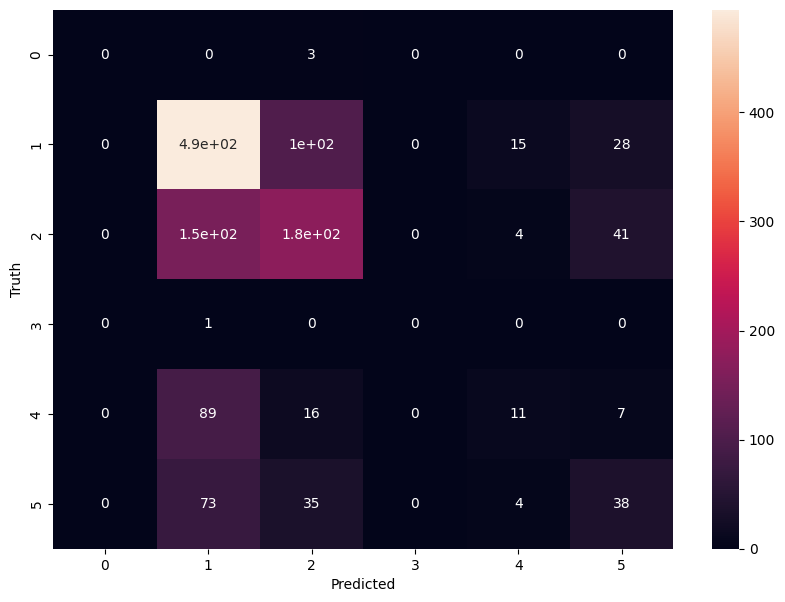

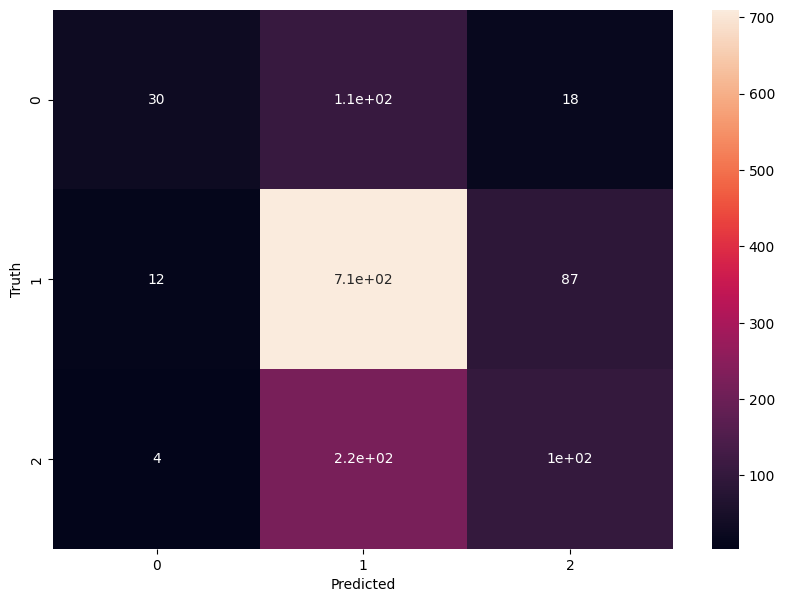

In [17]:
# Visualization of the results
if relevance:
    cm = confusion_matrix(y_R_test, y_R_pred)
    print("Relevance Confusion Matrix: ")
    print(cm)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
if polarity:
    cm = confusion_matrix(y_P_test, y_P_pred)
    print("Polarity Confusion Matrix: ")
    print(cm)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    